In [ ]:
import numpy as np

class RandomProcess:
    def __init__(self):
        pass

class Particle:
    def __init__(self,):
        self.present_position: np.ndarray # Dimension of the space.
        self.present_velocity: np.ndarray 
        self.present_time: int

    def Init_Random_Speed(self):
        self.present_velocity = np.random.randn(self.present_position.shape[0])
        pass
    
    def Init_Required_Speed(self,speed):
        self.present_velocity = speed
        pass

    def move(self,acceleration):
        

In [2]:
import pandas as pd 
import geopandas as gpd
import os
import skmob 
BaseDir = os.environ["WORKSPACE"]
OutputDir = os.path.join(BaseDir,"city-pro","output","bologna_mdt_detailed")
CartoDir = os.path.join(BaseDir,"city-pro") 
GeoJson = gpd.read_file(os.path.join(CartoDir,"bologna-provincia.geojson"))
Day = "2022-05-12"
BaseName = "bologna_mdt"
LowDash = "_"
PathsFile = BaseName + LowDash + Day + LowDash + Day + LowDash + "paths_on_road.csv"
TrajFile = BaseName + LowDash + Day + LowDash + Day + LowDash + "traj_dataframe.csv"
DfPaths = pd.read_csv(os.path.join(OutputDir,PathsFile),sep = ";")
TDfTraj = skmob.TrajDataFrame(pd.read_csv(os.path.join(OutputDir,TrajFile),sep = ";"))


In [30]:
IdRoadGeoJson = "poly_lid"
PathsId = "poly_id"
UserIds = DfPaths["user_id"].unique()



In [ ]:
import matplotlib.pyplot as plt
def PlotTraj(DfPaths,GeoJson,UserId):
    FirstPath = DfPaths.groupby("user_id").get_group(UserId)
    GeoJson = GeoJson.rename(columns={"poly_lid": PathsId})
    # Merge the filtered paths with the GeoJSON data to get the geometries
    MergedGdf = FirstPath.merge(GeoJson, on=PathsId)
    # Convert the merged DataFrame to a GeoDataFrame
    MergedGdf = gpd.GeoDataFrame(MergedGdf, geometry="geometry")
    # Plot the base map (roads)
    base = GeoJson.plot(color='gray', figsize=(10, 10))
    # Plot the filtered paths with a specific color
    MergedGdf.plot(ax=base, linewidth=2, color='blue', label=f'Trajectory {UserIds[10]}')
    plt.legend()
    plt.title(f'Trajectories on Road Map for user_id {UserId}')
    plt.show()
for i in range(10):
    PlotTraj(DfPaths,GeoJson,UserIds[i])


In [39]:
from shapely.geometry import Polygon
from shapely.ops import unary_union
from shapely.geometry import box
import numpy as np

def create_grid(gdf, grid_size_x, grid_size_y):
    """
    Create a grid for the smallest bounding box that contains all the geometries in the GeoDataFrame.

    Parameters:
    gdf (GeoDataFrame): Input GeoDataFrame with variable geometry types.
    grid_size_x (float): Width of the grid squares in meters.
    grid_size_y (float): Height of the grid squares in meters.

    Returns:
    GeoDataFrame: GeoDataFrame containing the grid.
    """
    # Extract the original CRS
    original_crs = gdf.crs

    # Reproject to a CRS that uses meters (e.g., UTM)
    gdf_meters = gdf.to_crs(epsg=32633)  # Example: UTM zone 33N, change as needed

    # Calculate the bounding box of the reprojected GeoDataFrame
    minx, miny, maxx, maxy = gdf_meters.total_bounds

    # Generate the grid points
    x_coords = np.arange(minx, maxx, grid_size_x)
    y_coords = np.arange(miny, maxy, grid_size_y)
    
    grid_cells = []
    for x in x_coords:
        for y in y_coords:
            grid_cells.append(box(x, y, x + grid_size_x, y + grid_size_y))
    
    grid_meters = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=gdf_meters.crs)
    
    # Clip the grid to the bounding box
    bbox = box(minx, miny, maxx, maxy)
    bbox_gdf = gpd.GeoDataFrame(geometry=[bbox], crs=gdf_meters.crs)
    grid_meters = gpd.overlay(grid_meters, bbox_gdf, how='intersection')
    
    # Add centroid and area columns
    grid_meters['centroidx'] = grid_meters.geometry.centroid.x
    grid_meters['centroidy'] = grid_meters.geometry.centroid.y
    grid_meters['area'] = grid_meters.geometry.area
    
    # Reproject the grid back to the original CRS
    grid = grid_meters.to_crs(original_crs)
    
    return grid
Grid = create_grid(GeoJson,1000,1000)

In [40]:
Grid

,geometry,centroidx,centroidy,area
0,"POLYGON ((10.81407 44.00199, 10.81470 43.99301...",163897.472743,4.880118e+06,1000000.000000
1,"POLYGON ((10.81344 44.01097, 10.81407 44.00199...",163897.472743,4.881118e+06,1000000.000000
2,"POLYGON ((10.81281 44.01995, 10.81344 44.01097...",163897.472743,4.882118e+06,1000000.000000
3,"POLYGON ((10.81217 44.02893, 10.81281 44.01995...",163897.472743,4.883118e+06,1000000.000000
4,"POLYGON ((10.81154 44.03791, 10.81217 44.02893...",163897.472743,4.884118e+06,1000000.000000
...,...,...,...,...
8272,"POLYGON ((11.85567 44.81867, 11.85518 44.82766...",251713.798721,4.968118e+06,632651.956342
8273,"POLYGON ((11.85518 44.82766, 11.85469 44.83665...",251713.798721,4.969118e+06,632651.956342
8274,"POLYGON ((11.85469 44.83665, 11.85420 44.84564...",251713.798721,4.970118e+06,632651.956342
8275,"POLYGON ((11.85420 44.84564, 11.85371 44.85463...",251713.798721,4.971118e+06,632651.956342


<Axes: >

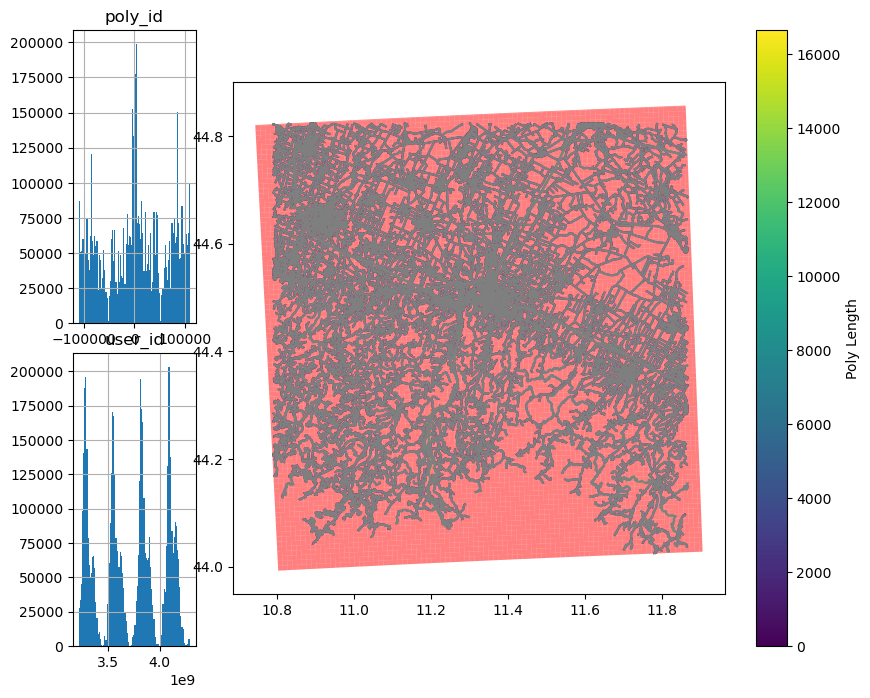

In [37]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors



fig = plt.figure(figsize=(10, 8))  # Adjust the figsize to accommodate the new layout
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 5], height_ratios=[1, 1], wspace=0.1, hspace=0.1)

axl_top = fig.add_subplot(gs[0, 0])
axl_bottom = fig.add_subplot(gs[1, 0])
axr = fig.add_subplot(gs[:, 1])

DfPaths.hist(column="user_id", bins=100, ax=axl_bottom)
DfPaths.hist(column="poly_id", bins=100, ax=axl_top)
cmap = 'viridis'
norm = mcolors.Normalize(vmin=GeoJson['poly_length'].min(), vmax=GeoJson['poly_length'].max())
GeoJson.plot(ax=axr, column='poly_length', cmap=cmap, legend=False)
Grid.plot(ax=axr, color="red", alpha=0.5)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axr)
cbar.set_label('Poly Length')
GeoJson.plot(ax=axr, color="gray")


AttributeError: module 'geopandas.plotting' has no attribute '_flatten_multi_geoms'

In [ ]:
fig, ax = plt.subplots(1, figsize=(1280/100, 720/100))
step_df = list_step_polars[0]
cbar_label = 'French polarization'
cmap = mcolors.LinearSegmentedColormap.from_list('my_cmap', conv_kinds_c[[0, 1, 3]])
plot_kwargs = {'edgecolor': (0.9, 0.9, 0.9), 'linewidths': 0.2, 'cmap': cmap}
metric_col = 'fr_polar'
mask = step_df[metric_col].notnull()
fig, ax = grid_viz.plot_grid(
    step_df.loc[mask], shape_df, metric_col=metric_col, ax=ax, fig=fig, show=False,
    cbar_label=cbar_label, cbar_lw=0, vmin=0, vmax=1,# cax=cax_maps,
    show_axes=False, borderwidth=0.5, tight_layout=False,
    **{'plot': plot_kwargs})
for c in ax.get_children():
    if isinstance(c, PatchCollection):
        ec = c.get_ec()
        if len(ec) > 0:
            if np.all(ec[0,:-1] == np.asarray(plot_kwargs['edgecolor'])):
                collec = c
geoms, multiindex = geopd.plotting._flatten_multi_geoms(step_df.loc[mask].geometry)

axins = inset_axes(ax, width='100%', height='100%',
                   bbox_to_anchor=(0, 0, 0.4, 0.4),
                   bbox_transform=ax.transAxes)
c_evol_values = [fun_c_value(t) for t in t_steps]
line, = axins.step(t_steps, c_evol_values, color='k')
axins.set_xlabel('step')
axins.set_ylabel('c')
axins.set_xlim(0, 23000)
axins.set_ylim(bottom=0)
axins.spines['right'].set_visible(False)
axins.spines['top'].set_visible(False)
# step_text = ax.annotate('step 1', (0, -0.05), xycoords='axes fraction')
def animate(i, t_steps, list_step_polars, multiindex, c_evol_values):
#     step = t_steps[i]
    collec.set_array(list_step_polars[i].loc[mask, metric_col].values[multiindex])
#     step_text.set_text(f'step {step}\n c = {fun_c_value(step):.2g}')
    line.set_data(t_steps[:i], c_evol_values[:i])
    return collec, line #, step_text

anim_args = np.arange(len(list_step_polars))
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, anim_args, fargs=[t_steps, list_step_polars, multiindex, c_evol_values],
                               interval=100, blit=True, repeat=False)
anim.save('BE_borders.mp4', dpi=200)